<a name='T'>

<p style="padding: 20px;
          background-color: black;
          font-family: computermodern;
          color: white;
          font-size: 200%;
          text-align: center;
          border-radius: 40px 20px;
          ">March ML Mania 2025: AutoGluon and Pals Powered by Optuna with GPU integration <br>
          </p>
<p style="font-family: computermodern;
          color: #000000;
          font-size: 175%;
          text-align: center;
          ">Notebook created by Alexandre Le Mercier<br>
            Inspired by a template from Jocelyn Dumlao<br>
             </p>
             

![](https://storage.googleapis.com/kaggle-media/competitions/kaggle/4862/media/bball-logo.png)

# 🏀 Tournament Predictor: AutoML and Pals 

Welcome! This notebook is designed to predict match outcomes using **state-of-the-art machine learning models** with automated hyperparameter tuning. We leverage **Optuna** for optimization and support multiple models, including:  

✅ **Tree-based models**:  
- XGBoost, LightGBM, ExtraTrees, HistGradientBoosting, CatBoost (CPU & GPU support)  

✅ **Support Vector Machines**:  
- Optimized SVC with GPU acceleration (ThunderSVM) when available  

✅ **Deep Learning**:  
- Sequential Neural Networks with dynamic architecture tuning  

✅ **AutoML**:  
- AutoGluon, a powerful ensemble-based framework  

## 🔍 Key Features  
- **GPU Acceleration**: Enables GPU if available for models that support it  
- **Optuna Optimization**: Finds the best hyperparameters in a **fixed time** instead of a fixed number of trials  
- **Cross-Validation**: 5-fold for tuning, 20-fold for validation to ensure **robust performance**  
- **Automatic Logging**: Saves optimal configurations and results with timestamps  

## 🚀 How to Use  
1. **Choose your accelerator** - the code will automatically use CPU or GPU based on your choice  
2. **Run the notebook** – it will automatically detect the best model  
3. **Check `optuna_log_*.txt`** – for optimal parameters and scores  
4. **Use the generated submission file** to submit your best predictions

Special thanks to Jocelyn Dumlao for the nice template I used to implement my working environment!

*NB: The code currently optimizes cross‐validated log loss (which is very similar to Brier score/MSE when used on probabilities) rather than directly optimizing the Brier score as defined in the competition. This is a common proxy.*

# 📚 Installing AutoGluon and Imports

In [1]:
!pip install autogluon.tabular
!pip install scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.2/352.2 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.2/266.2 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.1/64.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.2/68.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 86.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [2]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import joblib
import warnings
import shutil
warnings.filterwarnings('ignore')

# Models and regressors
import sklearn
from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor, RandomForestRegressor
import xgboost
from xgboost import XGBRegressor
import lightgbm as lgb
import catboost
from catboost import CatBoostRegressor
# For SVC, conditionally import either scikit-learn or ThunderSVM for GPU-accelerated SVC
try:
    from thundersvm import SVC as GPU_SVC
    gpu_svc_available = True
except ImportError:
    from sklearn.svm import SVC
    gpu_svc_available = False

# For AutoGluon
import autogluon
from autogluon.tabular import TabularPredictor
from autogluon.core.metrics import make_scorer
from sklearn.metrics import brier_score_loss

# Preprocessing and evaluation
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import log_loss, mean_squared_error, roc_curve, auc

# Hyperparameter optimization and progress bars
import optuna
from tqdm.notebook import tqdm
optuna.logging.set_verbosity(optuna.logging.WARNING)

# For neural network models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logs
tf.get_logger().setLevel('ERROR')  # Suppress Keras logs

# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    USE_GPU = True
    print("GPU is available. Using GPU acceleration where possible.\n")
else:
    USE_GPU = False
    print("GPU is not available. Running on CPU.\n")


for lib in [pd, np, sns, joblib, sklearn, xgboost, lgb, catboost, autogluon.tabular, tf, optuna]:
    print(lib.__name__, lib.__version__)

GPU is not available. Running on CPU.

pandas 2.2.3
numpy 1.26.4
seaborn 0.12.2
joblib 1.4.2
sklearn 1.5.2
xgboost 2.0.3
lightgbm 4.5.0
catboost 1.2.7
autogluon.tabular 1.2
tensorflow 2.17.1
optuna 4.2.0


In [3]:
data_dir = '/kaggle/input/march-machine-learning-mania-2025/**'

# ⚙️ Create the Optimization Environment

In [4]:
def brier_metric(y_true, y_pred):
    # y_pred should be the predicted probability for the positive class
    return brier_score_loss(y_true, y_pred)

# Create a scorer with the name "brier_score".
brier_scorer = make_scorer("brier_score", brier_metric, optimum=0, greater_is_better=False)

In [5]:
class TournamentPredictor:
    def __init__(self, data_dir, models_to_run=None, optuna_enabled=True,
                 optuna_timeout=300, splits_KFold_optuna=5, splits_KFold_validation=20):
        """
        data_dir: glob pattern for the CSV files.
        models_to_run: list of model names to run; default runs ExtraTrees, XGBoost, LightGBM, HistGradientBoosting.
                     Additional options: 'SVC', 'NN', 'CatBoost', and 'AutoGluon'.
        optuna_enabled: if True, each model’s hyperparameters will be tuned using Optuna.
        optuna_timeout: optimization timeout (in seconds) per model.
        splits_KFold_optuna: number of folds to use in the Optuna optimization.
        splits_KFold_validation: number of folds for the final cross-validation.
        """
        self.data_path = data_dir
        self.optuna_enabled = optuna_enabled
        self.optuna_timeout = optuna_timeout
        self.splits_KFold_optuna = splits_KFold_optuna
        self.splits_KFold_validation = splits_KFold_validation
        if models_to_run is None:
            self.models_to_run = ['ExtraTrees', 'XGBoost', 'LightGBM', 'HistGradientBoosting']
        else:
            self.models_to_run = models_to_run

        self.data = {}
        self.teams = None
        self.seeds = None
        self.games = None
        self.sub = None
        self.gb = None
        self.col = None  # feature column names
        self.models = {}  # raw (unfitted) model instances (after tuning)
        self.trained_models = {}  # fitted models (trained on training data)
        self.calibration_models = {}  # calibration models for each main model

        # For logging
        self.log_lines = []

        # To store cross-validation scores and ROC data per model.
        self.cv_scores = {}  # key: model_name, value: avg CV LB score (Brier)
        self.roc_data = {}   # key: model_name, value: (fpr, tpr, roc_auc)

        self.imputer = SimpleImputer(strategy='mean')
        self.scaler = StandardScaler()
        self.use_gpu = USE_GPU

    def load_data(self):
        # (Data loading code remains the same)
        files = glob.glob(self.data_path)
        self.data = {os.path.basename(p).split('.')[0]: pd.read_csv(p, encoding='latin-1') for p in files}
        teams = pd.concat([self.data['MTeams'], self.data['WTeams']])
        teams_spelling = pd.concat([self.data['MTeamSpellings'], self.data['WTeamSpellings']])
        teams_spelling = teams_spelling.groupby(by='TeamID', as_index=False)['TeamNameSpelling'].count()
        teams_spelling.columns = ['TeamID', 'TeamNameCount']
        self.teams = pd.merge(teams, teams_spelling, how='left', on=['TeamID'])
        season_cresults = pd.concat([self.data['MRegularSeasonCompactResults'], self.data['WRegularSeasonCompactResults']])
        season_dresults = pd.concat([self.data['MRegularSeasonDetailedResults'], self.data['WRegularSeasonDetailedResults']])
        tourney_cresults = pd.concat([self.data['MNCAATourneyCompactResults'], self.data['WNCAATourneyCompactResults']])
        tourney_dresults = pd.concat([self.data['MNCAATourneyDetailedResults'], self.data['WNCAATourneyDetailedResults']])
        seeds_df = pd.concat([self.data['MNCAATourneySeeds'], self.data['WNCAATourneySeeds']])
        self.seeds = {'_'.join(map(str, [int(k1), k2])): int(v[1:3])
                      for k1, v, k2 in seeds_df[['Season', 'Seed', 'TeamID']].values}
        self.sub = self.data['SampleSubmissionStage2']
        season_cresults['ST'] = 'S'
        season_dresults['ST'] = 'S'
        tourney_cresults['ST'] = 'T'
        tourney_dresults['ST'] = 'T'
        self.games = pd.concat((season_dresults, tourney_dresults), axis=0, ignore_index=True)
        self.games['WLoc'] = self.games['WLoc'].map({'A': 1, 'H': 2, 'N': 3})
        self.games['ID'] = self.games.apply(lambda r: '_'.join(map(str, [r['Season']] + sorted([r['WTeamID'], r['LTeamID']])),), axis=1)
        self.games['IDTeams'] = self.games.apply(lambda r: '_'.join(map(str, sorted([r['WTeamID'], r['LTeamID']]))), axis=1)
        self.games['Team1'] = self.games.apply(lambda r: sorted([r['WTeamID'], r['LTeamID']])[0], axis=1)
        self.games['Team2'] = self.games.apply(lambda r: sorted([r['WTeamID'], r['LTeamID']])[1], axis=1)
        self.games['IDTeam1'] = self.games.apply(lambda r: '_'.join(map(str, [r['Season'], r['Team1']])), axis=1)
        self.games['IDTeam2'] = self.games.apply(lambda r: '_'.join(map(str, [r['Season'], r['Team2']])), axis=1)
        self.games['Team1Seed'] = self.games['IDTeam1'].map(self.seeds).fillna(0)
        self.games['Team2Seed'] = self.games['IDTeam2'].map(self.seeds).fillna(0)
        self.games['ScoreDiff'] = self.games['WScore'] - self.games['LScore']
        self.games['Pred'] = self.games.apply(lambda r: 1.0 if sorted([r['WTeamID'], r['LTeamID']])[0] == r['WTeamID'] else 0.0, axis=1)
        self.games['ScoreDiffNorm'] = self.games.apply(lambda r: r['ScoreDiff'] * -1 if r['Pred'] == 0.0 else r['ScoreDiff'], axis=1)
        self.games['SeedDiff'] = self.games['Team1Seed'] - self.games['Team2Seed']
        self.games = self.games.fillna(-1)
        c_score_col = ['NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA',
                       'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF',
                       'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA',
                       'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']
        c_score_agg = ['sum', 'mean', 'median', 'max', 'min', 'std', 'skew', 'nunique']
        self.gb = self.games.groupby(by=['IDTeams']).agg({k: c_score_agg for k in c_score_col}).reset_index()
        self.gb.columns = [''.join(c) + '_c_score' for c in self.gb.columns]
        self.games = self.games[self.games['ST'] == 'T']
        self.sub['WLoc'] = 3
        self.sub['Season'] = self.sub['ID'].map(lambda x: int(x.split('_')[0]))
        self.sub['Team1'] = self.sub['ID'].map(lambda x: x.split('_')[1])
        self.sub['Team2'] = self.sub['ID'].map(lambda x: x.split('_')[2])
        self.sub['IDTeams'] = self.sub.apply(lambda r: '_'.join(map(str, [r['Team1'], r['Team2']])), axis=1)
        self.sub['IDTeam1'] = self.sub.apply(lambda r: '_'.join(map(str, [r['Season'], r['Team1']])), axis=1)
        self.sub['IDTeam2'] = self.sub.apply(lambda r: '_'.join(map(str, [r['Season'], r['Team2']])), axis=1)
        self.sub['Team1Seed'] = self.sub['IDTeam1'].map(self.seeds).fillna(0)
        self.sub['Team2Seed'] = self.sub['IDTeam2'].map(self.seeds).fillna(0)
        self.sub['SeedDiff'] = self.sub['Team1Seed'] - self.sub['Team2Seed']
        self.sub = self.sub.fillna(-1)
        self.games = pd.merge(self.games, self.gb, how='left', left_on='IDTeams', right_on='IDTeams_c_score')
        self.sub = pd.merge(self.sub, self.gb, how='left', left_on='IDTeams', right_on='IDTeams_c_score')
        exclude_cols = ['ID', 'DayNum', 'ST', 'Team1', 'Team2', 'IDTeams',
                        'IDTeam1', 'IDTeam2', 'WTeamID', 'WScore', 'LTeamID', 'LScore',
                        'NumOT', 'Pred', 'ScoreDiff', 'ScoreDiffNorm', 'WLoc'] + c_score_col
        self.col = [c for c in self.games.columns if c not in exclude_cols]
        print("Data loading and preprocessing completed.")

    # ----- Optimization functions now use brier_score_loss (LB score) -----
    def optimize_extratrees(self, X, y):
        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 500),
                'max_depth': trial.suggest_int('max_depth', 5, 30),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
            }
            model = ExtraTreesRegressor(random_state=42, n_jobs=-1, **params)
            kf = KFold(n_splits=self.splits_KFold_optuna, shuffle=True, random_state=42)
            scores = []
            for train_idx, val_idx in kf.split(X):
                model.fit(X[train_idx], y[train_idx])
                preds = model.predict(X[val_idx]).clip(0.001, 0.999)
                scores.append(brier_score_loss(y[val_idx], preds))
            return np.mean(scores)
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, timeout=self.optuna_timeout, show_progress_bar=True)
        self.log_lines.append("ExtraTrees best params: " + str(study.best_params))
        print("ExtraTrees best params:", study.best_params)
        return study.best_params

    def optimize_xgboost(self, X, y):
        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 500),
                'max_depth': trial.suggest_int('max_depth', 3, 15),
                'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
                'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
                'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0)
            }
            if self.use_gpu:
                params.update({'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'device': 'cuda'})
            model = XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror', **params)
            kf = KFold(n_splits=self.splits_KFold_optuna, shuffle=True, random_state=42)
            scores = []
            for train_idx, val_idx in kf.split(X):
                model.fit(X[train_idx], y[train_idx], verbose=False)
                preds = model.predict(X[val_idx]).clip(0.001, 0.999)
                scores.append(brier_score_loss(y[val_idx], preds))
            return np.mean(scores)
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, timeout=self.optuna_timeout, show_progress_bar=True)
        self.log_lines.append("XGBoost best params: " + str(study.best_params))
        print("XGBoost best params:", study.best_params)
        return study.best_params

    def optimize_lightgbm(self, X, y):
        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 500),
                'max_depth': trial.suggest_int('max_depth', 3, 15),
                'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
                'num_leaves': trial.suggest_int('num_leaves', 20, 150),
                'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
            }
            if self.use_gpu:
                params.update({'device': 'gpu'})
            model = lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1, **params)
            kf = KFold(n_splits=self.splits_KFold_optuna, shuffle=True, random_state=42)
            scores = []
            for train_idx, val_idx in kf.split(X):
                model.fit(X[train_idx], y[train_idx])
                preds = model.predict(X[val_idx]).clip(0.001, 0.999)
                scores.append(brier_score_loss(y[val_idx], preds))
            return np.mean(scores)
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, timeout=self.optuna_timeout, show_progress_bar=True)
        self.log_lines.append("LightGBM best params: " + str(study.best_params))
        print("LightGBM best params:", study.best_params)
        return study.best_params

    def optimize_histgb(self, X, y):
        def objective(trial):
            params = {
                'max_iter': trial.suggest_int('max_iter', 50, 500),
                'max_depth': trial.suggest_int('max_depth', 3, 15),
                'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20)
            }
            model = HistGradientBoostingRegressor(random_state=42,
                                                  max_iter=params['max_iter'],
                                                  max_depth=params['max_depth'],
                                                  learning_rate=params['learning_rate'],
                                                  min_samples_leaf=params['min_samples_leaf'])
            kf = KFold(n_splits=self.splits_KFold_optuna, shuffle=True, random_state=42)
            scores = []
            for train_idx, val_idx in kf.split(X):
                model.fit(X[train_idx], y[train_idx])
                preds = model.predict(X[val_idx]).clip(0.001, 0.999)
                scores.append(brier_score_loss(y[val_idx], preds))
            return np.mean(scores)
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, timeout=self.optuna_timeout, show_progress_bar=True)
        self.log_lines.append("HistGradientBoosting best params: " + str(study.best_params))
        print("HistGradientBoosting best params:", study.best_params)
        return study.best_params

    def optimize_svc(self, X, y):
        from sklearn.model_selection import StratifiedKFold
        def objective(trial):
            if self.use_gpu and gpu_svc_available:
                kernel_options = ['linear', 'rbf', 'poly', 'sigmoid', 'laplacian']
            else:
                kernel_options = ['linear', 'rbf', 'poly', 'sigmoid']
            params = {
                'C': trial.suggest_loguniform('C', 1e-2, 1e2),
                'kernel': trial.suggest_categorical('kernel', kernel_options),
            }
            if params['kernel'] in ['rbf', 'poly', 'sigmoid', 'laplacian']:
                params['gamma'] = trial.suggest_loguniform('gamma', 1e-4, 1e-1)
            if params['kernel'] in ['poly', 'sigmoid']:
                params['coef0'] = trial.suggest_uniform('coef0', 0, 1)
            if self.use_gpu and gpu_svc_available:
                model = GPU_SVC(probability=True, random_state=42, **params)
            else:
                model = SVC(probability=True, random_state=42, **params)
            skf = StratifiedKFold(n_splits=self.splits_KFold_optuna, shuffle=True, random_state=42)
            losses = []
            for train_idx, val_idx in skf.split(X, y):
                model.fit(X[train_idx], y[train_idx])
                preds = model.predict_proba(X[val_idx])[:, 1]
                losses.append(brier_score_loss(y[val_idx], preds))
            return np.mean(losses)
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, timeout=self.optuna_timeout, show_progress_bar=True)
        self.log_lines.append("SVC best params: " + str(study.best_params))
        print("SVC best params:", study.best_params)
        return study.best_params

    def optimize_nn(self, X, y):
        from tensorflow.keras import regularizers
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        input_dim = X.shape[1]
    
        def build_model(trial):
            # Choose architecture type and number of layers (increased maximum layers)
            arch = trial.suggest_categorical('arch', ['funnel', 'uniform'])
            num_layers = trial.suggest_int('num_layers', 2, 6)
            dropout_rate = trial.suggest_uniform('dropout', 0.0, 0.5)
            activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'elu'])
            learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
            use_batchnorm = trial.suggest_categorical('use_batchnorm', [True, False])
            l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-2)
            optimizer_choice = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    
            # Choose optimizer based on hyperparameter
            if optimizer_choice == 'adam':
                optimizer = Adam(learning_rate=learning_rate)
            else:
                from tensorflow.keras.optimizers import RMSprop
                optimizer = RMSprop(learning_rate=learning_rate)
    
            model = Sequential()
            # Determine layer sizes based on architecture type
            if arch == 'funnel':
                first_units = trial.suggest_int('first_units', 64, 512)
                units_list = [first_units]
                for i in range(1, num_layers):
                    units_list.append(max(8, int(first_units * (0.5 ** i))))
            else:
                units = trial.suggest_int('units', 32, 256)
                units_list = [units] * num_layers
    
            # Build the network layers with optional batch normalization and L2 regularization
            model.add(Dense(units_list[0], input_dim=input_dim, activation=activation,
                            kernel_regularizer=regularizers.l2(l2_reg)))
            if use_batchnorm:
                from tensorflow.keras.layers import BatchNormalization
                model.add(BatchNormalization())
            model.add(Dropout(dropout_rate))
            for units in units_list[1:]:
                model.add(Dense(units, activation=activation, kernel_regularizer=regularizers.l2(l2_reg)))
                if use_batchnorm:
                    model.add(BatchNormalization())
                model.add(Dropout(dropout_rate))
            model.add(Dense(1, activation='sigmoid'))
            model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
            return model

        def objective(trial):
            model = build_model(trial)
            # Train for a fixed number of epochs; you may adjust this as needed.
            history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                                epochs=20, batch_size=32, verbose=0)
            val_preds = model.predict(X_val, verbose=0).ravel().clip(0.001, 0.999)
            # Use Brier score as the LB metric.
            val_lb = brier_score_loss(y_val, val_preds)
            # Apply a complexity penalty based on the number of parameters.
            param_count = model.count_params()
            penalty = abs(param_count - 10000) / 10000.0
            return val_lb + penalty * 0.5
    
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, timeout=self.optuna_timeout, show_progress_bar=True)
        self.log_lines.append("NN best params: " + str(study.best_params))
        print("NN best params:", study.best_params)
        return study.best_params


    def optimize_catboost(self, X, y):
        def objective(trial):
            params = {
                'iterations': trial.suggest_int('iterations', 100, 500),
                'depth': trial.suggest_int('depth', 3, 10),
                'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
                'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1, 10)
            }
            params['task_type'] = 'GPU' if self.use_gpu else 'CPU'
            model = CatBoostRegressor(random_state=42, verbose=0, **params)
            kf = KFold(n_splits=self.splits_KFold_optuna, shuffle=True, random_state=42)
            scores = []
            for train_idx, val_idx in kf.split(X):
                model.fit(X[train_idx], y[train_idx])
                preds = model.predict(X[val_idx]).clip(0.001, 0.999)
                scores.append(brier_score_loss(y[val_idx], preds))
            return np.mean(scores)
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, timeout=self.optuna_timeout, show_progress_bar=True)
        self.log_lines.append("CatBoost best params: " + str(study.best_params))
        print("CatBoost best params:", study.best_params)
        return study.best_params

    def optimize_autogluon(self, X, y):
        # Convert X to DataFrame using self.col and add target
        df = pd.DataFrame(X, columns=self.col)
        df['target'] = y
        train_data = df.sample(frac=0.8, random_state=42)
        val_data = df.drop(train_data.index)
        def objective(trial):
            hyperparameters = {
                'GBM': {
                    'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
                    'num_boost_round': trial.suggest_int('num_boost_round', 50, 300)
                }
            }
            if self.use_gpu:
                hyperparameters['GBM']['task_type'] = 'GPU'
            timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            unique_path = f"AutogluonModels_{timestamp}/"
            predictor = TabularPredictor(label='target', eval_metric=brier_scorer, path=unique_path).fit(
                    train_data, hyperparameters=hyperparameters, time_limit=60, verbosity=0)
            preds = predictor.predict_proba(val_data).iloc[:, 1].values
            score = brier_score_loss(val_data['target'], preds)
            return score
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, timeout=self.optuna_timeout, show_progress_bar=True)
        self.log_lines.append("AutoGluon best params: " + str(study.best_params))
        print("AutoGluon best params:", study.best_params)
        return study.best_params

    # ----- Create models (with or without tuning) -----
    def create_models(self):
        X = self.games[self.col].fillna(-1).values
        X_imputed = self.imputer.fit_transform(X)
        X_scaled = self.scaler.fit_transform(X_imputed)
        y = self.games['Pred'].values.astype(int)
        
        for model_name in self.models_to_run:
            print(f"\nCreating model: {model_name}")
            if self.optuna_enabled:
                if model_name == 'ExtraTrees':
                    best_params = self.optimize_extratrees(X_scaled, y)
                    model = ExtraTreesRegressor(random_state=42, n_jobs=-1, **best_params)
                elif model_name == 'XGBoost':
                    best_params = self.optimize_xgboost(X_scaled, y)
                    if self.use_gpu:
                        best_params.update({'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'device': 'cuda'})
                    model = XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror', **best_params)
                elif model_name == 'LightGBM':
                    best_params = self.optimize_lightgbm(X_scaled, y)
                    if self.use_gpu:
                        best_params.update({'device': 'gpu'})
                    model = lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1, **best_params)
                elif model_name == 'HistGradientBoosting':
                    best_params = self.optimize_histgb(X_scaled, y)
                    model = HistGradientBoostingRegressor(random_state=42,
                                                          max_iter=best_params['max_iter'],
                                                          max_depth=best_params['max_depth'],
                                                          learning_rate=best_params['learning_rate'],
                                                          min_samples_leaf=best_params['min_samples_leaf'])
                elif model_name == 'SVC':
                    best_params = self.optimize_svc(X_scaled, y)
                    if self.use_gpu and gpu_svc_available:
                        model = GPU_SVC(probability=True, random_state=42, **best_params)
                    else:
                        model = SVC(probability=True, random_state=42, **best_params)
                elif model_name == 'NN':
                    y_float = self.games['Pred'].values.astype(np.float32)
                    best_params = self.optimize_nn(X_scaled, y_float)
                    def build_final_nn():
                        arch = best_params['arch']
                        num_layers = best_params['num_layers']
                        dropout_rate = best_params['dropout']
                        activation = best_params['activation']
                        learning_rate = best_params['learning_rate']
                        if arch == 'funnel':
                            first_units = best_params['first_units']
                            units_list = [first_units]
                            for i in range(1, num_layers):
                                units_list.append(max(8, first_units // (2 ** i)))
                        else:
                            units = best_params['units']
                            units_list = [units] * num_layers
                        model = Sequential()
                        model.add(Dense(units_list[0], input_dim=X_scaled.shape[1], activation=activation))
                        model.add(Dropout(dropout_rate))
                        for units in units_list[1:]:
                            model.add(Dense(units, activation=activation))
                            model.add(Dropout(dropout_rate))
                        model.add(Dense(1, activation='sigmoid'))
                        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy')
                        return model
                    model = build_final_nn()
                elif model_name == 'CatBoost':
                    best_params = self.optimize_catboost(X_scaled, y)
                    best_params['task_type'] = 'GPU' if self.use_gpu else 'CPU'
                    model = CatBoostRegressor(random_state=42, verbose=0, **best_params)
                elif model_name == 'AutoGluon':
                    best_params = self.optimize_autogluon(X_scaled, y)
                    hyperparameters = {
                        'GBM': {
                            'learning_rate': best_params['learning_rate'],
                            'num_boost_round': best_params['num_boost_round']
                        }
                    }
                    if self.use_gpu:
                        hyperparameters['GBM']['task_type'] = 'GPU'
                    df = pd.DataFrame(X_scaled, columns=self.col)
                    df['target'] = y
                    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
                    unique_path = f"AutogluonModels_{timestamp}/"
                    predictor = TabularPredictor(label='target', eval_metric=brier_scorer, path=unique_path).fit(
                        df, hyperparameters=hyperparameters, time_limit=60, verbosity=0)
                    model = predictor
                else:
                    print(f"Model {model_name} not recognized. Skipping.")
                    continue
            else:
                if model_name == 'ExtraTrees':
                    model = ExtraTreesRegressor(n_estimators=235, max_depth=15, min_samples_split=2,
                                                max_features='sqrt', random_state=42, n_jobs=-1)
                elif model_name == 'XGBoost':
                    params = {'n_estimators':235, 'max_depth':15, 'learning_rate':0.1, 'subsample':0.8,
                              'colsample_bytree':0.8, 'gamma':0}
                    if self.use_gpu:
                        params.update({'tree_method':'gpu_hist','predictor':'gpu_predictor','device':'cuda'})
                    model = XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror', **params)
                elif model_name == 'LightGBM':
                    params = {'n_estimators':235, 'max_depth':15, 'learning_rate':0.1, 'num_leaves':31,
                              'subsample':0.8, 'colsample_bytree':0.8}
                    if self.use_gpu:
                        params.update({'device':'gpu'})
                    model = lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1, **params)
                elif model_name == 'HistGradientBoosting':
                    model = HistGradientBoostingRegressor(max_iter=235, max_depth=15, learning_rate=0.1,
                                                           min_samples_leaf=1, random_state=42)
                elif model_name == 'SVC':
                    if self.use_gpu and gpu_svc_available:
                        model = GPU_SVC(probability=True, random_state=42, C=1.0, kernel='linear')
                    else:
                        model = SVC(probability=True, random_state=42, C=1.0, kernel='linear')
                elif model_name == 'NN':
                    model = Sequential([
                        Dense(128, input_dim=X_scaled.shape[1], activation='relu'),
                        Dropout(0.2),
                        Dense(64, activation='relu'),
                        Dropout(0.2),
                        Dense(32, activation='relu'),
                        Dense(1, activation='sigmoid')
                    ])
                    model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy')
                elif model_name == 'CatBoost':
                    params = {'iterations':235, 'depth':6, 'learning_rate':0.1, 'l2_leaf_reg':3,
                              'task_type': 'GPU' if self.use_gpu else 'CPU'}
                    model = CatBoostRegressor(random_state=42, verbose=0, **params)
                elif model_name == 'AutoGluon':
                    hyperparameters = {'GBM': {'learning_rate': 0.1, 'num_boost_round': 235}}
                    if self.use_gpu:
                        hyperparameters['GBM']['task_type'] = 'GPU'
                    df = pd.DataFrame(X_scaled, columns=self.col)
                    df['target'] = y
                    model = TabularPredictor(label='target', eval_metric=brier_scorer).fit(
                        df, hyperparameters=hyperparameters, time_limit=60, verbosity=0)
                else:
                    continue
            self.models[model_name] = model
            print(f"{model_name} model created.")

    def train_and_evaluate_models(self):
        X = self.games[self.col].fillna(-1)
        X_imputed = self.imputer.transform(X)
        X_scaled = self.scaler.fit_transform(X_imputed)
        y = self.games['Pred'].values
        y_int = y.astype(int)

        self.trained_models = {}
        self.calibration_models = {}

        kf = KFold(n_splits=self.splits_KFold_validation, shuffle=True, random_state=42)
        X_train_full, X_cal, y_train_full, y_cal = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

        for model_name, model in self.models.items():
            print(f"\nTraining and evaluating model: {model_name}")
            if model_name == 'SVC':
                model.fit(X_train_full, y_int[:len(X_train_full)])
                train_preds = model.predict_proba(X_train_full)[:, 1]
            elif model_name == 'NN':
                model.fit(X_train_full, y_train_full, epochs=10, batch_size=32, verbose=0)
                train_preds = model.predict(X_train_full, verbose=0).ravel().clip(0.001, 0.999)
            elif model_name == 'AutoGluon':
                df_train = pd.DataFrame(X_train_full, columns=self.col)
                df_train['target'] = y_train_full
                train_preds = model.predict(df_train).values.astype(float)
            else:
                model.fit(X_train_full, y_train_full)
                train_preds = model.predict(X_train_full).clip(0.001, 0.999)
            calib_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
            calib_model.fit(train_preds.reshape(-1, 1), y_train_full)
            train_preds_calibrated = calib_model.predict(train_preds.reshape(-1, 1)).clip(0.001, 0.999)
            tloss = brier_score_loss(y_train_full, train_preds_calibrated)
            print(f'{model_name} - LB Score (Train): {tloss:.4f}')
            self.log_lines.append(f"{model_name} Train LB Score: {tloss:.4f}")
            cv_mse_scores = []
            cv_lb_scores = []
            for train_idx, val_idx in kf.split(X_scaled):
                if model_name == 'SVC':
                    model.fit(X_scaled[train_idx], y_int[train_idx])
                    val_preds = model.predict_proba(X_scaled[val_idx])[:, 1]
                elif model_name == 'NN':
                    model.fit(X_scaled[train_idx], y[train_idx], epochs=10, batch_size=32, verbose=0)
                    val_preds = model.predict(X_scaled[val_idx], verbose=0).ravel().clip(0.001, 0.999)
                elif model_name == 'AutoGluon':
                    df_val = pd.DataFrame(X_scaled[val_idx], columns=self.col)
                    val_preds = model.predict(df_val).values.astype(float)
                else:
                    model.fit(X_scaled[train_idx], y[train_idx])
                    val_preds = model.predict(X_scaled[val_idx]).clip(0.001, 0.999)
                calib_model.fit(val_preds.reshape(-1, 1), y[val_idx])
                val_preds_calibrated = calib_model.predict(val_preds.reshape(-1, 1)).clip(0.001, 0.999)
                cv_mse_scores.append(np.mean((y[val_idx] - val_preds_calibrated) ** 2))
                cv_lb_scores.append(brier_score_loss(y[val_idx], val_preds_calibrated))
            avg_cv_lb = np.mean(cv_lb_scores)
            print(f'{model_name} - Cross-validated LB Score: {avg_cv_lb:.4f}')
            self.log_lines.append(f"{model_name} CV LB Score: {avg_cv_lb:.4f}")
            self.cv_scores[model_name] = avg_cv_lb
            self.trained_models[model_name] = model
            self.calibration_models[model_name] = calib_model
            if model_name == 'SVC':
                cal_preds = model.predict_proba(X_cal)[:, 1]
            elif model_name == 'NN':
                cal_preds = model.predict(X_cal, verbose=0).ravel().clip(0.001, 0.999)
            elif model_name == 'AutoGluon':
                df_cal = pd.DataFrame(X_cal, columns=self.col)
                cal_preds = model.predict(df_cal).values.astype(float)
            else:
                cal_preds = model.predict(X_cal).clip(0.001, 0.999)
            cal_preds_calibrated = calib_model.predict(cal_preds.reshape(-1, 1)).clip(0.001, 0.999)
            fpr, tpr, _ = roc_curve(y_cal, cal_preds_calibrated)
            roc_auc = auc(fpr, tpr)
            self.roc_data[model_name] = (fpr, tpr, roc_auc)
        self.best_model_name = min(self.cv_scores, key=self.cv_scores.get)
        self.best_score = self.cv_scores[self.best_model_name]
        print(f"\nBest model: {self.best_model_name} with CV LB Score: {self.best_score:.4f}")
        self.log_lines.append(f"Best model: {self.best_model_name} with CV LB Score: {self.best_score:.4f}")
                # Select the two best models based on CV LB Score
        sorted_models = sorted(self.cv_scores.items(), key=lambda x: x[1])
        best_two = sorted_models[:2]
        print("\nBest two models:")
        for model_name, score in best_two:
            print(f"  {model_name}: CV LB Score = {score:.4f}")
            self.log_lines.append(f"Best model candidate: {model_name} with CV LB Score: {score:.4f}")
        
        # Save the two best models
        for model_name, score in best_two:
            if model_name == 'NN':
                model_path = f"{score:.4f}_{model_name}_model.keras"
                self.trained_models[model_name].save(model_path)
            elif model_name == 'AutoGluon':
                model_path = f"{score:.4f}_{model_name}_predictor.ag"
                self.trained_models[model_name].save(model_path)
            else:
                model_path = f"{score:.4f}_{model_name}_model.pkl"
                joblib.dump(self.trained_models[model_name], model_path)
            print(f"{model_name} saved as: {model_path}")
            self.log_lines.append(f"{model_name} saved as: {model_path}")
        self.plot_roc_curves()

    def plot_roc_curves(self):
        plt.figure(figsize=(10, 8))
        for model_name, (fpr, tpr, roc_auc) in self.roc_data.items():
            plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color
                 ='gray', lw=1, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves Comparison')
        plt.legend(loc="lower right")
        plt.tight_layout()
        roc_fig_path = "roc_comparison.png"
        plt.savefig(roc_fig_path)
        plt.show()
        print(f"ROC curves saved as: {roc_fig_path}")
        self.log_lines.append(f"ROC curves saved as: {roc_fig_path}")

    def predict_submission(self, output_file=None):
        sub_X = self.sub[self.col].fillna(-1)
        sub_X_imputed = self.imputer.transform(sub_X)
        sub_X_scaled = self.scaler.transform(sub_X_imputed)
        best_model = self.trained_models[self.best_model_name]
        calib_model = self.calibration_models[self.best_model_name]
        if self.best_model_name == 'SVC':
            preds = best_model.predict_proba(sub_X_scaled)[:, 1]
        elif self.best_model_name == 'NN':
            preds = best_model.predict(sub_X_scaled, verbose=0).ravel().clip(0.001, 0.999)
        elif self.best_model_name == 'AutoGluon':
            df_sub = pd.DataFrame(sub_X_scaled, columns=self.col)
            preds = best_model.predict(df_sub).values.astype(float)
        else:
            preds = best_model.predict(sub_X_scaled).clip(0.001, 0.999)
        preds_calibrated = calib_model.predict(preds.reshape(-1, 1)).clip(0.001, 0.999)
        self.sub['Pred'] = preds_calibrated
        if output_file is None:
            output_file = f"{self.best_score:.4f}_{self.best_model_name}_submission.csv"
        self.sub[['ID', 'Pred']].to_csv(output_file, index=False)
        print(f"Submission file saved to {output_file}")
        self.log_lines.append(f"Submission file saved to {output_file}")

    def write_log(self):
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        log_filename = f"optuna_log_{timestamp}.txt"
        with open(log_filename, "w") as f:
            for line in self.log_lines:
                f.write(line + "\n")
        print(f"Log file saved as: {log_filename}")

    def run_all(self):
        self.load_data()
        self.create_models()
        self.train_and_evaluate_models()
        self.predict_submission()
        self.write_log()

# 🏆 Best Model Selection and Insights

Data loading and preprocessing completed.

Creating model: SVC


   0%|          | 00:00/1:00:00

SVC best params: {'C': 10.50599704754028, 'kernel': 'poly', 'gamma': 0.00046031297225425995, 'coef0': 0.24808843804796366}
SVC model created.

Creating model: AutoGluon


   0%|          | 00:00/1:00:00

AutoGluon best params: {'learning_rate': 0.12553182465048443, 'num_boost_round': 74}
AutoGluon model created.

Training and evaluating model: SVC
SVC - LB Score (Train): 0.1897
SVC - Cross-validated LB Score: 0.0383

Training and evaluating model: AutoGluon
AutoGluon - LB Score (Train): 0.1424
AutoGluon - Cross-validated LB Score: 0.1336

Best model: SVC with CV LB Score: 0.0383

Best two models:
  SVC: CV LB Score = 0.0383
  AutoGluon: CV LB Score = 0.1336
SVC saved as: 0.0383_SVC_model.pkl
AutoGluon saved as: 0.1336_AutoGluon_predictor.ag


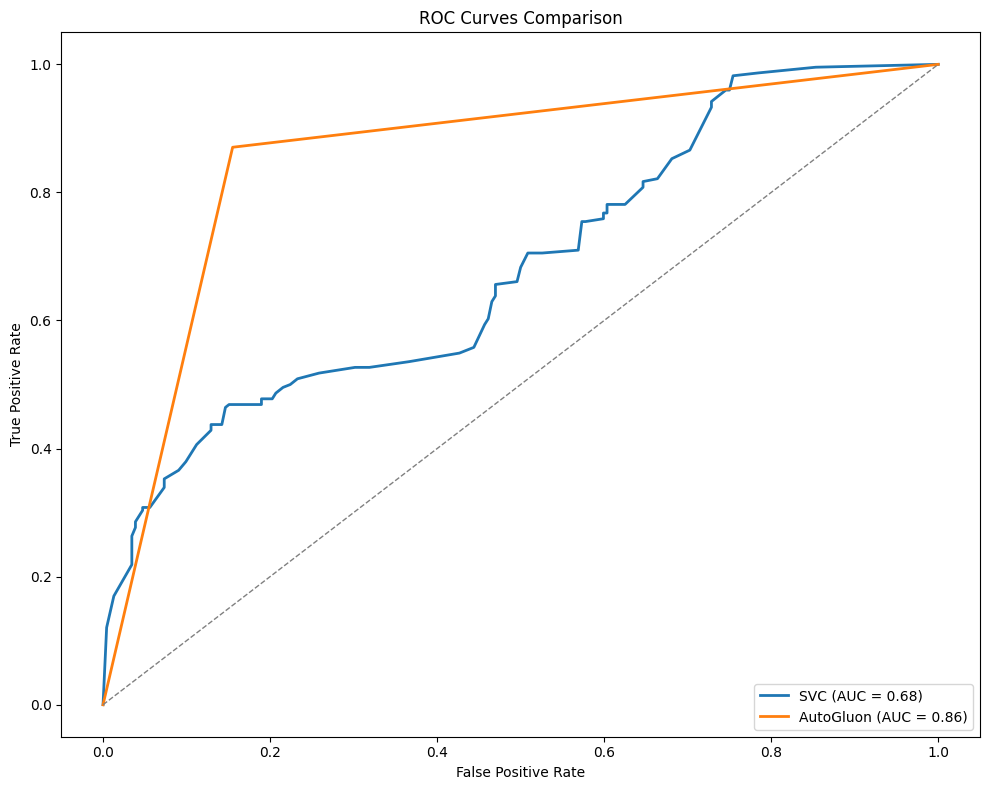

ROC curves saved as: roc_comparison.png
Submission file saved to 0.0383_SVC_submission.csv
Log file saved as: optuna_log_20250223_172841.txt


In [6]:
predictor = TournamentPredictor(
    data_dir='/kaggle/input/march-machine-learning-mania-2025/*.csv',
    #models_to_run=['AutoGluon', 'SVC', 'ExtraTrees', 'XGBoost', 'LightGBM', 'HistGradientBoosting', 'NN', 'CatBoost'],
    models_to_run=['SVC', 'AutoGluon'],
    optuna_enabled=True,
    splits_KFold_optuna=10, # Balance confidence and training time
    splits_KFold_validation=40, # Higher confidence needed for validation
    optuna_timeout=3600  # seconds per model optimization
)
predictor.run_all()

<p style="padding: 20px;
          background-color: green;
          font-family: computermodern;
          color: white;
          font-size: 200%;
          text-align: center;
          border-radius: 40px 20px;
          ">Thank you! If you found this useful please like 👍</p>

<div style="display: flex; justify-content: space-between; align-items: flex-start;">
        <a href="https://www.linkedin.com/in/alexandre-le-mercier-7b5594283/" target="_blank" style="display: inline-block; background-color: #003f88; color: #fff; text-decoration: none; padding: 5px 10px; border-radius: 10px; margin: 15px;">LinkedIn</a>
        <a href="https://github.com/TortueSagace" target="_blank" style="display: inline-block; background-color: transparent; color: #059c99; text-decoration: none; padding: 5px 10px; border-radius: 10px; margin: 15px; border: 2px solid #007bff;">GitHub</a>
        <a href="https://www.kaggle.com/alexandrelemercier" target="_blank" style="display: inline-block; background-color: #3a86ff; color: #fff; text-decoration: none; padding: 5px 10px; border-radius: 10px; margin: 15px;">Kaggle</a>
    </div>
</div>